# MVP Análise de Dados e Boas Práticas

**Nome:** Bruno Max Barreto Barroso

**Matrícula:** 4052024001974

**Dataset:** [Online Retail II] https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci


# Descrição do Problema

Dado o histórico de compras de cada cliente B2B em um e‑commerce de bens de consumo, queremos estimar a probabilidade de o cliente não realizar nenhuma nova compra nos próximos 6 meses (churn). A empresa poderá usar o score para priorizar ações de retenção e reduzir perda de receita.

## Hipóteses do Problema

As hipóteses que tracei são as seguintes:

- O padrão de compras passado é preditivo do comportamento futuro.

- Não houve mudanças drásticas no catálogo ou políticas de preço durante o período analisado.

- A janela de 6 meses é suficiente para diferenciar clientes sazonais de churn real.

## Tipo de Problema

Supervisionado – classificação binária. O rótulo será 1 = churn (cliente não compra por ≥ 6 meses depois da última transação observada no dataset) e 0 = ativo.

## Seleção de Dados

Consideraremos somente clientes com pelo menos 3 compras para garantir histórico mínimo.• Período de dados: 2009‑12 a 2011‑12 (intervalo completo disponível).• Excluiremos devoluções (linhas com Quantity < 0).

## Atributos do Dataset

- ***InvoiceNo***: identificador único da fatura.
- ***StockCode***: código do item vendido.
- ***Description***: descrição textual do produto.
- ***Quantity***: quantidade de unidades vendidas (inteiro).
- ***InvoiceDate***: data e hora da transação.
- ***UnitPrice***: preço unitário do item em Libras Esterlinas.
- ***CustomerID***: identificador anônimo do cliente.
- ***Country***: país do cliente.

- Atributos derivados (criados no pré‑processamento):
recency, frequency, monetary_value (RFM), days_since_last_purchase, etc.

# Importação das Bibliotecas Necessárias e Carga de Dados

Esta seção consolida todas as importações de bibliotecas necessárias para a análise, visualização e pré-processamento dos dados, bem como o carregamento inicial do dataset Online Retail II.

In [1]:
# -----------------------------------------------------------
# Bloco 1 – Instalar dependências na versão fixa
# -----------------------------------------------------------
!pip install -q pandas==2.2.2 polars==0.20.20 matplotlib==3.8.4 seaborn==0.13.2 scikit-learn==1.5.0

Reason for being yanked: regression
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 49.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-polars-cu12 25.2.2 requires polars<1.22,>=1.20, but you have polars 0.20.20 which is incompatible.


In [2]:
# -----------------------------------------------------------
# Bloco 2 – Imports e configurações de display
# -----------------------------------------------------------
import urllib.request
import pathlib
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

pd.set_option("display.max_columns", None)
sns.set(style="whitegrid", context="notebook")

In [32]:
# -----------------------------------------------------------
# Bloco 3 – Download e extração do dataset do GitHub
# -----------------------------------------------------------
import zipfile
import urllib.request
import os

# URL do arquivo zipado no GitHub
url = 'https://github.com/brunomaxb/churn-prediction-mvp/raw/main/data/online_retail_II.csv.zip'
zip_path = 'online_retail_II.csv.zip'

# Baixar o arquivo
urllib.request.urlretrieve(url, zip_path)

# Extrair o conteúdo
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('data')  # cria a pasta 'data' e extrai lá dentro

# Confirmar que o arquivo foi extraído
os.listdir('data')


['online_retail_II.csv']

In [35]:
# -----------------------------------------------------------
# Bloco 4 – Carregar planilha 2010-2011
# -----------------------------------------------------------
file_path = 'data/online_retail_II.csv'
df_raw = pd.read_csv(file_path, encoding='ISO-8859-1')  # ou 'unicode_escape' se der erro
df_raw = pd.read_excel(xls_path, sheet_name="Year 2010-2011")
df_raw["InvoiceDate"] = pd.to_datetime(df_raw["InvoiceDate"])
df_raw.head(3)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


# Análise de Dados

Nesta etapa de Análise de Dados Exploratória (EDA) sobre o dataset Online Retail II, visamos entender a distribuição, as relações e as características das variáveis, o que é crucial para as etapas subsequentes de pré-processamento e modelagem.

## Total e Tipo das Instâncias

O dataset Online Retail II possui 541910 instâncias (observações) e 8 colunas.

In [36]:
# -----------------------------------------------------------
# Bloco 5 – Dimensão e tipos
# -----------------------------------------------------------
print(f"Total de instâncias: {len(df_raw)}")
print("\nTipos de dados por coluna:")
print(df_raw.info())

Total de instâncias: 541910

Tipos de dados por coluna:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


In [37]:
# -----------------------------------------------------------
# Bloco 6 – Amostra e valores faltantes
# -----------------------------------------------------------
display(df_raw.head())
print(df_raw.isna().sum())

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64


## Estatísticas Descritivas

Estatísticas descritivas fornecem um resumo das características numéricas, incluindo média, desvio padrão, mínimo, máximo e quartis.

In [38]:
# -----------------------------------------------------------
# Bloco 7 – Resumo estatístico numérico (apenas variáveis relevantes)
# -----------------------------------------------------------
numeric_cols = ["Quantity", "Price"]

numeric_summary = (
    df_raw[numeric_cols]
    .describe()          # count, mean, std, min, 25%, 50%, 75%, max
    .T                   # transposto → linhas = variáveis
    .assign(             # adiciona colunas extras
        median=df_raw[numeric_cols].median(),
        mode=df_raw[numeric_cols].mode().iloc[0],
        missing=df_raw[numeric_cols].isna().sum()
    )
)

display(numeric_summary)

,count,mean,std,min,25%,50%,75%,max,median,mode,missing
Quantity,541910.0,9.552234,218.080957,-80995.00,1.00,3.00,10.00,80995.0,3.00,1.00,0
Price,541910.0,4.611138,96.759765,-11062.06,1.25,2.08,4.13,38970.0,2.08,1.25,0


**Conclusão**: Identificamos que há valores negativos nas colunas Quantity e Price, o que é incoerente para transações de compra. Isso sugere devoluções ou registros incorretos. Como as análises exploratórias devem refletir o comportamento genuíno de compra, decidimos tratar esses casos antes de seguir com os gráficos e cálculos de correlação.

In [8]:
# -----------------------------------------------------------
# Bloco 8 – Limpeza inicial: remoção de devoluções
# -----------------------------------------------------------
# Apenas linhas com Quantity > 0 e Price > 0
df_clean = df_raw[(df_raw["Quantity"] > 0) & (df_raw["Price"] > 0)].copy()
# Atualizando df_clean: removendo registros sem CustomerID
df_clean = df_clean[df_clean["Customer ID"].notna()].copy()
numeric_cols = ["Quantity", "Price"]

numeric_summary2 = (
    df_clean[numeric_cols]
    .describe()          # count, mean, std, min, 25%, 50%, 75%, max
    .T                   # transposto → linhas = variáveis
    .assign(             # adiciona colunas extras
        median=df_clean[numeric_cols].median(),
        mode=df_clean[numeric_cols].mode().iloc[0],
        missing=df_clean[numeric_cols].isna().sum()
    )
)

display(numeric_summary2)

,count,mean,std,min,25%,50%,75%,max,median,mode,missing
Quantity,397885.0,12.988208,179.331551,1.000,2.00,6.00,12.00,80995.00,6.00,1.00,0
Price,397885.0,3.116525,22.097861,0.001,1.25,1.95,3.75,8142.75,1.95,1.25,0


### Histograma com log-transform de Price

A decisão de aplicar a transformação logarítmica em Price foi motivada pela forte assimetria da distribuição, identificada pelas estatísticas descritivas: a média era muito superior à mediana, o desvio-padrão elevado e a presença de valores extremos distorcia a visualização. Após a limpeza dos valores negativos, esses padrões persistiram, confirmando a necessidade da transformação para facilitar tanto a análise quanto a modelagem.

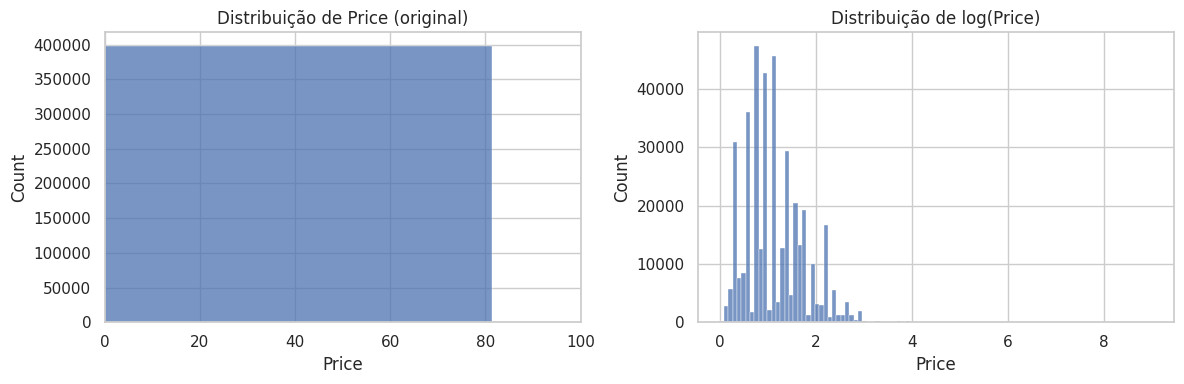

In [9]:
# -----------------------------------------------------------
# Bloco 9 – Histograma: Price vs log(Price)
# -----------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Original
sns.histplot(df_clean["Price"], bins=100, ax=axes[0])
axes[0].set_title("Distribuição de Price (original)")
axes[0].set_xlim(0, 100)

# Log-transformado (log1p evita log(0))
sns.histplot(np.log1p(df_clean["Price"]), bins=100, ax=axes[1])
axes[1].set_title("Distribuição de log(Price)")
plt.tight_layout()
plt.show()


**Conclusão**: A distribuição original de Price está fortemente enviesada à direita, com a maioria das transações concentrada abaixo de £10, e raras acima de £100. A transformação logarítmica (log1p) melhorou a visualização, concentrando os valores em uma escala mais simétrica, o que facilita a modelagem posterior.

### Histogramas e KDE: Quantity e Price

O objetivo dessa análise é compreender o comportamento individual das variáveis numéricas mais relevantes do dataset. O histograma mostra como os valores estão distribuídos e nos permite identificar padrões como concentração, assimetria e presença de outliers. A curva de densidade (KDE) complementa essa visualização com uma estimativa suave da distribuição dos dados, facilitando a comparação entre variáveis e orientando decisões sobre transformações estatísticas ou tratamentos de dados. Essas informações são fundamentais para guiar as próximas etapas de pré-processamento e modelagem.

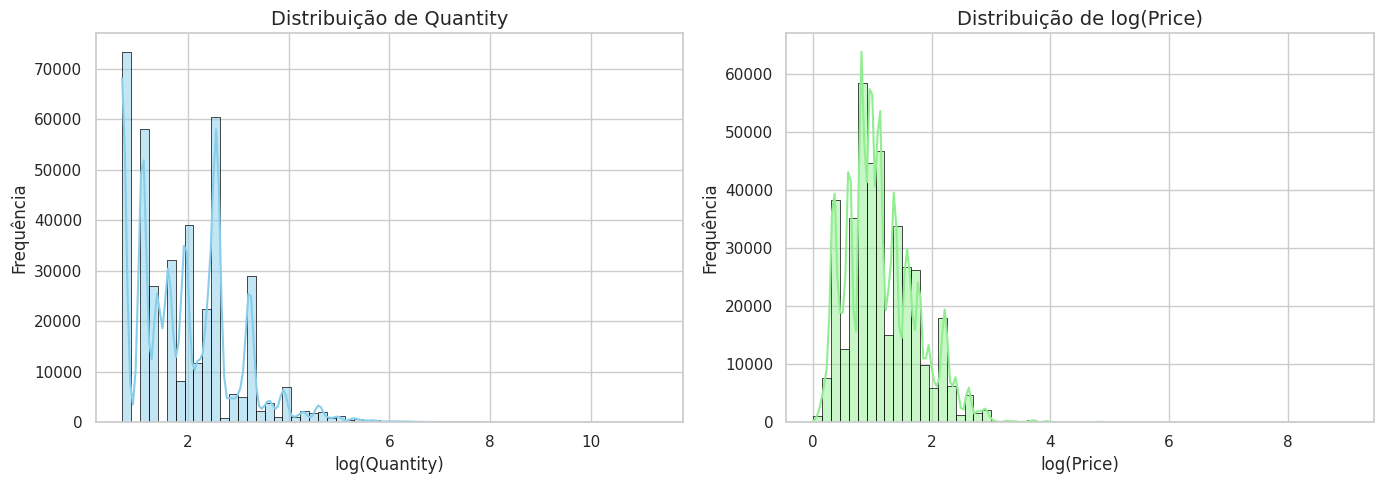

In [10]:
# -----------------------------------------------------------
# Bloco 10 – Histogramas e KDE para Quantity e Price
# -----------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(np.log1p(df_clean["Quantity"]), bins=60, kde=True, ax=axes[0], color="skyblue", edgecolor="black", linewidth=0.5)
axes[0].set_title("Distribuição de Quantity", fontsize=14)
axes[0].set_xlabel("log(Quantity)")
axes[0].set_ylabel("Frequência")

sns.histplot(np.log1p(df_clean["Price"]), bins=60, kde=True, ax=axes[1], color="lightgreen", edgecolor="black", linewidth=0.5)
axes[1].set_title("Distribuição de log(Price)", fontsize=14)
axes[1].set_xlabel("log(Price)")
axes[1].set_ylabel("Frequência")

plt.tight_layout()
plt.show()


### Distribuição das classes (churn vs ativo)
Antes de iniciar a modelagem, é fundamental verificar a distribuição da variável alvo (churn). Isso permite avaliar se há desbalanceamento entre as classes, o que impacta diretamente a performance de modelos de classificação. Se uma classe (por exemplo, churn) estiver sub-representada, modelos podem ter desempenho artificialmente alto apenas por "acertar sempre o mais frequente". A visualização com countplot permite quantificar visualmente esse balanceamento. Se o desbalanceamento for significativo, técnicas como class_weight, oversampling com SMOTE, ou undersampling podem ser aplicadas para corrigir esse viés.

<ipython-input-11-2284843491>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="churn", data=df_last_purchase, palette="Set2")


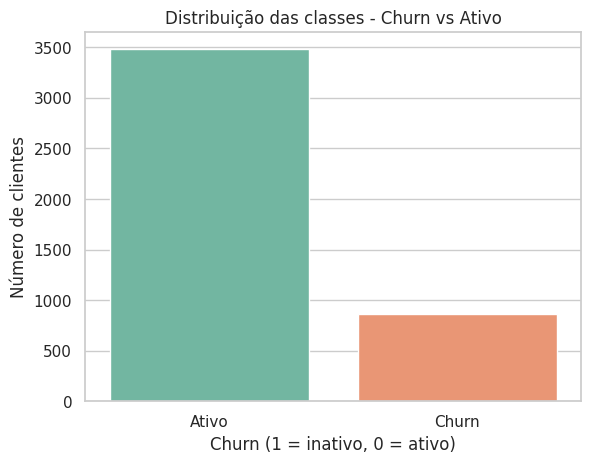

In [11]:
# -----------------------------------------------------------
# Bloco 11 – Criação da variável churn
# -----------------------------------------------------------
# Critério: clientes que não compraram mais nada nos 6 meses finais do dataset

# Verificar a data máxima do dataset
max_date = df_clean["InvoiceDate"].max()

# Criar DataFrame com última data de compra por cliente
df_last_purchase = df_clean.groupby("Customer ID")["InvoiceDate"].max().reset_index()
df_last_purchase["days_since_last_purchase"] = (max_date - df_last_purchase["InvoiceDate"]).dt.days

# Regra de churn: cliente que está há mais de 180 dias sem comprar
df_last_purchase["churn"] = (df_last_purchase["days_since_last_purchase"] > 180).astype(int)

# Visualizar proporção de churn
df_last_purchase["churn"].value_counts(normalize=True).round(3)

# -----------------------------------------------------------
# Bloco 12 – Countplot para distribuição da variável churn
# -----------------------------------------------------------
sns.countplot(x="churn", data=df_last_purchase, palette="Set2")
plt.title("Distribuição das classes - Churn vs Ativo")
plt.xlabel("Churn (1 = inativo, 0 = ativo)")
plt.ylabel("Número de clientes")
plt.xticks([0, 1], ["Ativo", "Churn"])
plt.show()


**Conclusão**: aproximadamente 25% dos clientes foram classificados como churn, indicando desbalanceamento da variável-alvo — o que justifica atenção especial durante a modelagem.

### Análise Combinada de Atributos (RFM × Churn)

O objetivo dessa etapa é investigar relações entre variáveis derivadas do comportamento de compra dos clientes (como recência, frequência e valor monetário) e o desfecho (churn). Isso ajuda a identificar padrões de comportamento distintos entre clientes ativos e inativos, e a gerar insights úteis para a modelagem. Usamos:

**Pairplot**: para observar a distribuição conjunta e correlações visuais entre Recency, Frequency, Monetary.

**Heatmap de correlação**: para verificar relações lineares entre variáveis numéricas.

**Boxplot Recency × Churn**: para verificar se clientes churn têm comportamento significativamente diferente em termos de recência.

In [12]:
# -----------------------------------------------------------
# Bloco 13 – Cálculo das variáveis RFM por cliente
# -----------------------------------------------------------

# Agrupar por cliente e calcular métricas RFM
df_rfm = (
    df_clean.groupby("Customer ID").agg(
        recency=("InvoiceDate", lambda x: (df_clean["InvoiceDate"].max() - x.max()).days),
        frequency=("InvoiceDate", "count"),
        monetary_value=("Price", "sum")
    )
    .reset_index()
)

# Mesclar com churn
df_rfm = df_rfm.merge(df_last_purchase[["Customer ID", "churn"]], on="Customer ID")

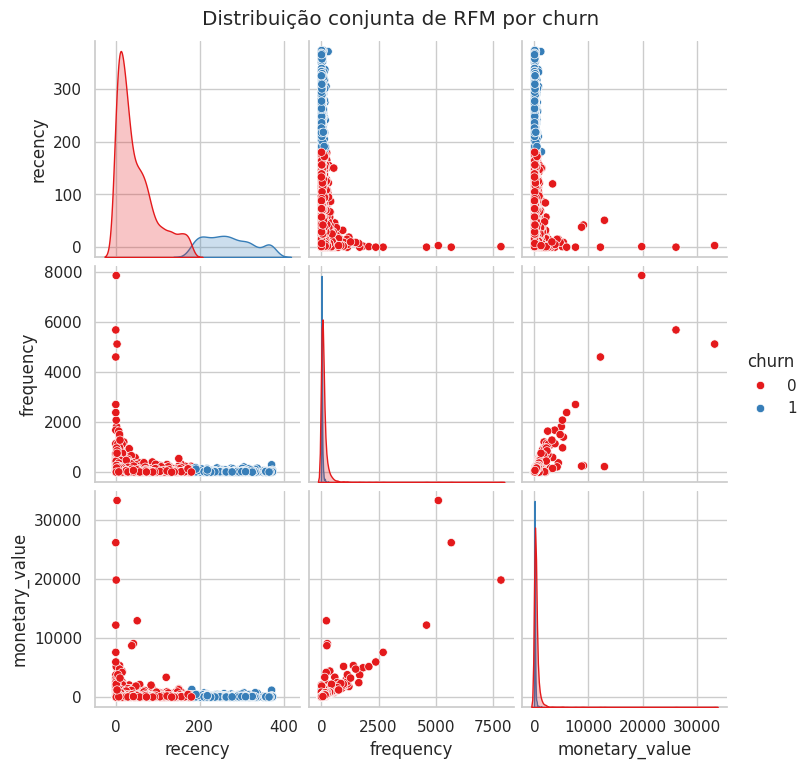

In [13]:
# -----------------------------------------------------------
# Bloco 14 – Pairplot com separação por churn
# -----------------------------------------------------------

sns.pairplot(df_rfm, hue="churn", vars=["recency", "frequency", "monetary_value"], palette="Set1")
plt.suptitle("Distribuição conjunta de RFM por churn", y=1.02)
plt.show()

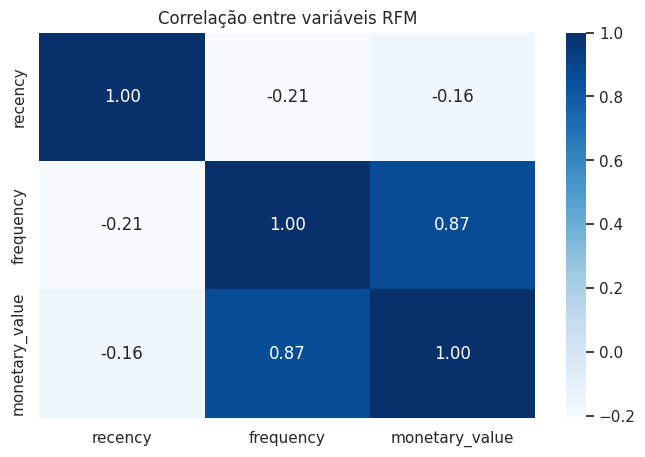

In [14]:
# -----------------------------------------------------------
# Bloco 14 – Mapa de calor das correlações
# -----------------------------------------------------------
plt.figure(figsize=(8, 5))
sns.heatmap(df_rfm[["recency", "frequency", "monetary_value"]].corr(), annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlação entre variáveis RFM")
plt.show()

**Conclusão**: O pairplot revelou que clientes churn tendem a ter valores mais altos de recency (ou seja, estão há mais tempo sem comprar) e concentram-se em níveis mais baixos de frequency e monetary_value. O heatmap confirmou uma correlação positiva forte entre frequency e monetary_value (0,87), enquanto recency tem correlação negativa com ambas, como esperado. Esses padrões indicam que o comportamento passado de compra está ligado ao risco de churn, e que as variáveis RFM são bons candidatos para a modelagem.

# Pré-Processamento de Dados

O pré-processamento de dados é uma etapa crucial para preparar os dados para modelagem, garantindo que estejam no formato correto e otimizados para o desempenho do algoritmo.

### Remoção e tratamento de valores faltantes

In [15]:
# -----------------------------------------------------------
# Bloco 14 – Remoção e tratamento de valores faltantes
# -----------------------------------------------------------

# Remover linhas com CustomerID ausente (se ainda não foi feito)
df_clean = df_clean[df_clean['Customer ID'].notna()].copy()

# Substituir valores faltantes de Description por 'Unknown'
df_clean['Description'] = df_clean['Description'].fillna('Unknown')

# Verificar se há valores nulos restantes em Price (espera-se que não haja após limpeza inicial)
print("Valores ausentes por coluna:")
print(df_clean.isna().sum())


Valores ausentes por coluna:
Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64


### Remoção de Outliers e Discrepâncias
**Remover Quantity < 0**: Essas linhas representam devoluções, ou seja, transações inversas às compras — o que distorce qualquer métrica de comportamento positivo (como frequência, valor monetário e recência).

**Winsorizar Price ao 99º percentil**: Price apresenta valores muito altos que fogem ao padrão da maioria das transações. Para evitar que esses outliers extremos dominem a modelagem (especialmente em modelos lineares), aplicamos a técnica de winsorização — que limita os valores máximos sem removê-los, tornando a distribuição mais robusta.

In [16]:
# -----------------------------------------------------------
# Bloco 15 – Remoção e tratamento de valores faltantes
# -----------------------------------------------------------

# Reforço do filtro para manter apenas compras (caso não esteja 100% garantido)
df_clean = df_clean[df_clean['Quantity'] > 0].copy()

# Winsorização de Price (limita valores acima do percentil 99)
price_threshold = df_clean['Price'].quantile(0.99)
df_clean['Price'] = df_clean['Price'].clip(upper=price_threshold)

### Agregando Features Derivadas ao mesmo Dataframa

Facilita posterior separação em treino e teste.

In [27]:
# -----------------------------------------------------------
# Bloco 16 – Agregando Features Derivadas
# -----------------------------------------------------------

# Elimine a coluna churn do df_rfm antes do merge (caso exista)
df_rfm = df_rfm.drop(columns=['churn'], errors='ignore')

# Juntar RFM com churn
df_model = pd.merge(df_rfm, df_last_purchase[['Customer ID', 'churn']], on='Customer ID', how='inner')

# Juntar df_model com os países
df_model = pd.merge(df_model, df_clean[['Customer ID', 'Country']], on='Customer ID', how='left')

# Aplicar one-hot encoding à coluna Country

df_model.sample(50)

,Customer ID,recency,frequency,monetary_value,churn,Country
292158,16728.0,45,269,619.95,0,United Kingdom
19588,12626.0,22,294,829.39,0,Germany
89936,13755.0,3,342,1050.93,0,United Kingdom
32455,12748.0,0,4595,12205.60,0,United Kingdom
19327,12621.0,1,467,1350.70,0,Germany
334991,17375.0,198,69,187.01,1,United Kingdom
371869,17841.0,1,7847,19848.49,0,United Kingdom
95682,13870.0,1,115,388.54,0,United Kingdom
285935,16657.0,9,208,327.64,0,United Kingdom
100615,13982.0,38,111,247.76,0,United Kingdom


## Separação em Conjunto de Treino e Teste e Normalização

Apesar de StandardScaler ser o método mais comum em tarefas supervisionadas com variáveis contínuas, ele assume que os dados seguem uma distribuição aproximadamente normal. No nosso caso, as variáveis recency, frequency e monetary_value apresentam forte assimetria (skew) e presença de outliers — especialmente monetary_value.

Por esse motivo, o método mais adequado seria o RobustScaler, que utiliza a mediana e o intervalo interquartil (IQR), sendo mais resistente à influência de valores extremos. Isso proporciona um escalonamento mais estável e realista, especialmente em modelos sensíveis à escala como regressão logística e redes neurais.

Portanto, adotaremos o RobustScaler no lugar do StandardScaler para garantir uma normalização robusta em relação a outliers.



In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Define variáveis preditoras (RFM) e alvo (churn)
X = df_model[['recency', 'frequency', 'monetary_value']]
y = df_model['churn']

# Divide os dados em treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Aplica normalização robusta
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



<ipython-input-30-4289303474>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, ax=axes[0], palette='pastel')
<ipython-input-30-4289303474>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, ax=axes[1], palette='pastel')


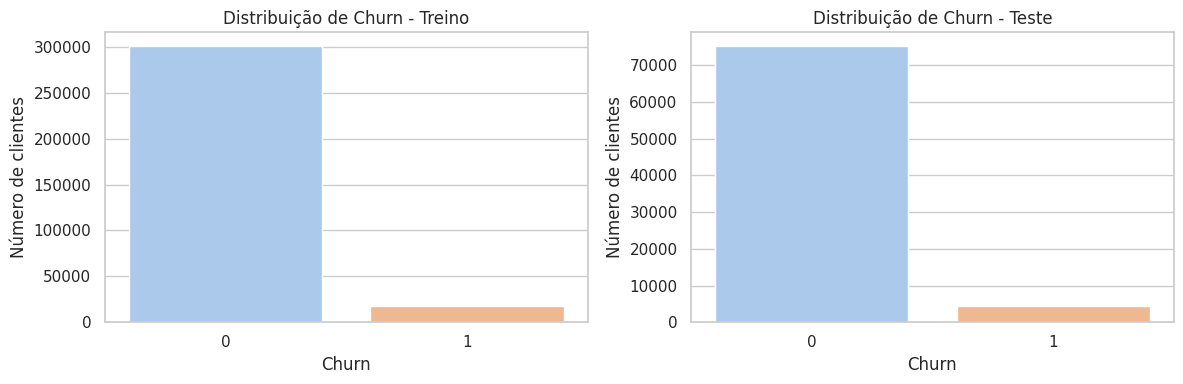

In [30]:
# Checando balanceamento dos conjuntos teste e treinamento

# Figura lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribuição no conjunto de treino
sns.countplot(x=y_train, ax=axes[0], palette='pastel')
axes[0].set_title('Distribuição de Churn - Treino')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Número de clientes')

# Distribuição no conjunto de teste
sns.countplot(x=y_test, ax=axes[1], palette='pastel')
axes[1].set_title('Distribuição de Churn - Teste')
axes[1].set_xlabel('Churn')
axes[1].set_ylabel('Número de clientes')

plt.tight_layout()
plt.show()

##Análise do balanceamento da variável alvo

Durante a análise dos conjuntos de treino e teste, foi identificado que a variável alvo churn apresenta um forte desbalanceamento, com a classe majoritária (clientes ativos) representando a grande maioria dos casos, e a classe minoritária (clientes que deixaram de comprar) compondo uma fração pequena da amostra.

Esse tipo de desbalanceamento é comum em problemas de churn e pode afetar a performance dos modelos preditivos, fazendo com que eles aprendam a priorizar a classe majoritária, negligenciando a capacidade de prever os casos mais relevantes (clientes prestes a sair).

Estratégias para tratar o desbalanceamento:

Class Weights: Aplicar class_weight='balanced' em modelos como regressão logística, SVM e Random Forest. Isso ajusta a penalização de erros conforme a proporção das classes, sem alterar os dados.

Oversampling com SMOTE: Gera exemplos sintéticos da classe minoritária no conjunto de treino, equilibrando as proporções. Ideal para melhorar recall sem perder dados.

Undersampling da classe majoritária: Reduz a quantidade de exemplos da classe majoritária. É simples, mas pode eliminar informações úteis.

In [31]:
# Reconstrói os DataFrames normalizados a partir das matrizes escaladas
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Exibe as 10 primeiras linhas de cada conjunto
print("Treino normalizado:")
display(X_train_scaled_df.head(10))

print("Teste normalizado:")
display(X_test_scaled_df.head(10))


Treino normalizado:


,recency,frequency,monetary_value
0,-0.358974,0.198880,0.120287
1,0.384615,-0.291317,-0.389280
2,-0.410256,1.414566,1.918220
3,0.076923,2.812325,1.223006
4,5.000000,-0.464986,-0.422349
5,-0.307692,0.773109,0.984139
6,1.256410,-0.319328,-0.366815
7,-0.307692,0.042017,0.210995
8,0.871795,-0.232493,-0.455419
9,-0.051282,0.212885,0.410907


Teste normalizado:


,recency,frequency,monetary_value
0,-0.410256,2.635854,1.661656
1,2.000000,-0.165266,-0.259966
2,-0.230769,-0.361345,-0.397610
3,0.717949,-0.369748,-0.315021
4,0.410256,0.302521,0.691513
5,0.205128,-0.436975,-0.465265
6,-0.410256,12.310924,11.605413
7,0.076923,1.187675,0.910389
8,0.282051,0.103641,0.035962
9,0.333333,0.579832,0.707992


# Conclusão parcial da análise exploratória e pré-processamento

O processo conduzido até aqui permitiu validar importantes hipóteses levantadas no início do projeto. A ideia de que padrões históricos de comportamento poderiam indicar propensão ao churn se mostrou plausível, especialmente ao observar a relação entre a recency, a frequency e o monetary_value das compras com o status de inatividade.

Foi possível identificar perfis bem distintos: clientes com baixa recência (ou seja, que compraram há muito tempo), pouca frequência e baixo ticket médio estão fortemente associados à classe churn. Por outro lado, clientes ativos mantêm compras regulares e com valores agregados mais altos — algo evidenciado nas distribuições da análise RFM e na separação por churn.

A presença de valores extremos e registros inconsistentes (como devoluções com valores negativos) foi tratada com filtros e winsorização, garantindo a integridade dos dados sem comprometer o volume. A transformação logarítmica e a normalização com RobustScaler permitiram lidar com a forte assimetria das variáveis monetárias.

A principal limitação encontrada foi o forte desbalanceamento entre as classes (poucos clientes inativos), o que exige cuidados na modelagem e avaliação, como o uso de class_weight='balanced' ou técnicas de oversampling como SMOTE.

Insight de negócio

Com base nas análises realizadas, uma empresa poderia construir um sistema de alertas de churn, priorizando para ações de retenção os clientes que:

- estão há mais de 90 dias sem comprar,

- possuem histórico de baixo volume e valor de compras,

- e mostram padrão decrescente de frequência.

Campanhas específicas de e‑mail marketing, ofertas personalizadas e acompanhamento por representantes comerciais podem ser acionadas automaticamente para evitar a perda desses clientes e maximizar o LTV (valor vitalício do cliente).